In [ ]:
#pip install optuna

In [ ]:
#library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import shap
import optuna
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('credit_scoring.csv')

In [ ]:
df.head()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
0,501000,41,13995609,5982664,0,624,0,0,-0.040
1,501001,58,13683833,3711198,0,809,0,0,0.001
2,501002,33,9417391,7172332,0,647,0,0,0.077
3,501003,45,6861811,8661056,0,450,0,0,0.038
4,501004,22,5640742,4520669,1,816,0,0,0.020


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   application_id     6000 non-null   int64  
 1   age                6000 non-null   int64  
 2   monthly_income     6000 non-null   int64  
 3   loan_amount        6000 non-null   int64  
 4   previous_defaults  6000 non-null   int64  
 5   credit_score       6000 non-null   int64  
 6   default            6000 non-null   int64  
 7   leak_col_good      6000 non-null   int64  
 8   leak_col_subtle    6000 non-null   float64
dtypes: float64(1), int64(8)
memory usage: 422.0 KB


In [ ]:
df.describe()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
count,6000.000000,6000.000000,6.000000e+03,6.000000e+03,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,503999.500000,40.321500,1.140386e+07,8.001122e+06,0.243667,575.979833,0.012167,0.012167,0.011945
std,1732.195139,11.300697,4.912598e+06,4.071786e+06,0.484767,158.328931,0.109639,0.109639,0.113947
min,501000.000000,21.000000,3.000310e+06,1.000794e+06,0.000000,300.000000,0.000000,0.000000,-0.119000
25%,502499.750000,31.000000,7.163379e+06,4.440939e+06,0.000000,438.750000,0.000000,0.000000,-0.020000
50%,503999.500000,41.000000,1.129945e+07,7.982304e+06,0.000000,577.500000,0.000000,0.000000,0.000000
75%,505499.250000,50.000000,1.573705e+07,1.153144e+07,0.000000,713.000000,0.000000,0.000000,0.021000
max,506999.000000,59.000000,1.998622e+07,1.499858e+07,3.000000,849.000000,1.000000,1.000000,1.092000


In [ ]:
df.isna().sum()

,0
application_id,0
age,0
monthly_income,0
loan_amount,0
previous_defaults,0
credit_score,0
default,0
leak_col_good,0
leak_col_subtle,0


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df = df.drop('leak_col_good', axis=1)

In [ ]:
df = df.drop('leak_col_subtle', axis=1)
df.head()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default
0,501000,41,13995609,5982664,0,624,0
1,501001,58,13683833,3711198,0,809,0
2,501002,33,9417391,7172332,0,647,0
3,501003,45,6861811,8661056,0,450,0
4,501004,22,5640742,4520669,1,816,0


EDA

In [ ]:
df_2 = df.copy()

Age Distribution

In [ ]:
df_2['age'] = pd.cut(df_2['age'], bins = [20, 30, 40, 50, 60],
                   labels = ['21-30', '31-40', '41-50', '51-60'])

In [ ]:
df_2.age.value_counts()

,count
age,
41-50,1559
31-40,1494
21-30,1487
51-60,1460


In [ ]:
age = df_2['age'].value_counts().sort_index()
age_df = age.reset_index()
age_df.columns = ['Age', 'Count']

fig = px.pie(age_df,
             names = 'Age',
             values = 'Count',
             title = 'Age Distribution')

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

Monthly Income Distribution

In [ ]:
df_2['monthly_income'] = pd.cut(df_2['monthly_income'], bins = [0, 7000000, 11000000, 15000000, 20000000],
                              labels = ['< 7 mio', '7 mio - 11 mio', '11 mio - 15 mio', '15 mio - 20 mio'])

In [ ]:
df_2.head()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default
0,501000,41-50,11 mio - 15 mio,5982664,0,624,0
1,501001,51-60,11 mio - 15 mio,3711198,0,809,0
2,501002,31-40,7 mio - 11 mio,7172332,0,647,0
3,501003,41-50,< 7 mio,8661056,0,450,0
4,501004,21-30,< 7 mio,4520669,1,816,0


In [ ]:
df_2.monthly_income.value_counts()

,count
monthly_income,
15 mio - 20 mio,1752
< 7 mio,1450
7 mio - 11 mio,1441
11 mio - 15 mio,1357


In [ ]:
income = df_2['monthly_income'].value_counts().sort_index()
income_df = income.reset_index()
income_df.columns = ['Monthly Income', 'Count']

fig = px.bar(income_df,
             x = 'Count',
             y = 'Monthly Income',
             orientation = 'h',
             title = 'Monthly Income Distribution',
             text = 'Count',
             color = 'Monthly Income')

fig.update_layout(showlegend = False)
fig.update_traces(textposition='outside')
fig.show()

Credit Score Distribution

In [ ]:
df_2['credit_score'] = pd.cut(df_2['credit_score'], bins = [300, 580, 670, 740, 800, 900],
                   labels = ['Poor (300-579)', 'Fair (580-669)', 'Good (670-739)', 'Very Good (740-779)', 'Excellent (800-850)'])

In [ ]:
df_2.credit_score.value_counts()

,count
credit_score,
Poor (300-579),3026
Fair (580-669),1004
Good (670-739),780
Very Good (740-779),649
Excellent (800-850),536


In [ ]:
credit = df_2['credit_score'].value_counts().sort_index()
credit_df = credit.reset_index()
credit_df.columns = ['Credit', 'Count']

fig = px.pie(credit_df,
             names = 'Credit',
             values = 'Count',
             title = 'Credit Score Distribution')

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

Correlation

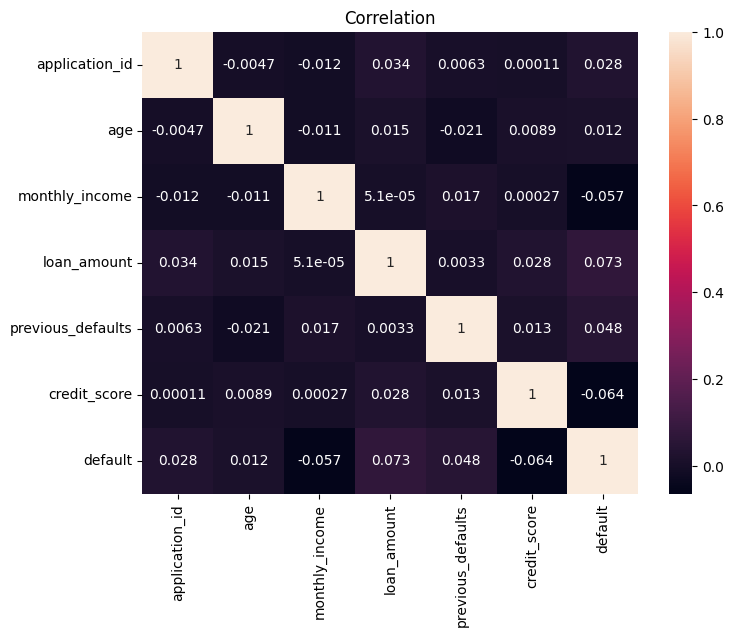

In [ ]:
plt.figure(figsize = (8,6))
sns.heatmap(df.corr(), annot = True)
plt.title('Correlation')
plt.show()

Modeling

In [ ]:
df_3 = df.copy()
df_3.head()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default
0,501000,41,13995609,5982664,0,624,0
1,501001,58,13683833,3711198,0,809,0
2,501002,33,9417391,7172332,0,647,0
3,501003,45,6861811,8661056,0,450,0
4,501004,22,5640742,4520669,1,816,0


In [ ]:
df_3['previous_defaults'].value_counts()

,count
previous_defaults,
0,4686
1,1170
2,140
3,4


In [ ]:
features_to_scale = ['age', 'monthly_income', 'loan_amount', 'credit_score']

scaler = StandardScaler()
df_3[features_to_scale] = scaler.fit_transform(df_3[features_to_scale])

In [ ]:
def prob_to_score(prob, base_score = 300, base_odds = 50, pdo = 20,
                  min_score = 300, max_score = 850):
    odds = (1 - prob)/prob
    factor = pdo / np.log(2)
    offset = base_score - factor * np.log(base_odds)
    raw_score = offset + factor * np.log(odds)

    score = np.round(np.clip(raw_score, min_score, max_score))
    return score

Logistic Regression

In [ ]:
X = df_3[['application_id','age', 'monthly_income', 'loan_amount', 'previous_defaults','credit_score']]
y = df_3['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

sm = SMOTE(random_state=42)
X_new, y_new = sm.fit_resample(X_train, y_train)

In [ ]:
model = LogisticRegression()
model.fit(X_new, y_new)

probs = model.predict_proba(X_test)[:, 1]
score = prob_to_score(probs)
y_pred_test = model.predict(X_test)

In [ ]:
X_test_result_1 = X_test.copy()
X_test_result_1['Actual'] = y_test.values
X_test_result_1['Predicted_Prob'] = probs
X_test_result_1['Credit_Score'] = score
X_test_result_1['Predicted_Label'] = y_pred_test

In [ ]:
X_test_result_1.head()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,Actual,Predicted_Prob,Credit_Score,Predicted_Label
1782,502782,0.325538,-1.525653,0.817582,1,-0.789434,0,0.804191,300.0,1
3917,504917,0.148543,-0.164390,0.066169,0,1.642415,0,0.211296,300.0,0
221,501221,-1.621407,-1.504865,1.248734,0,0.657042,0,0.710462,300.0,1
2135,503135,0.768025,-1.145478,1.068565,0,0.113824,0,0.765308,300.0,1
5224,506224,-0.293944,0.902016,-0.193665,0,1.212894,0,0.109481,300.0,0


In [ ]:
file_path_excel = 'X_test_result_lr.xlsx'
X_test_result_1.to_excel(file_path_excel, index=False)
print(f"DataFrame 'X_test_result' telah disimpan ke '{file_path_excel}'")

DataFrame 'X_test_result' telah disimpan ke 'X_test_result_lr.xlsx'


In [ ]:
X_test_result_1.head()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,Actual,Predicted_Prob,Credit_Score,Predicted_Label
1782,502782,0.325538,-1.525653,0.817582,1,-0.789434,0,0.804191,300.0,1
3917,504917,0.148543,-0.164390,0.066169,0,1.642415,0,0.211296,300.0,0
221,501221,-1.621407,-1.504865,1.248734,0,0.657042,0,0.710462,300.0,1
2135,503135,0.768025,-1.145478,1.068565,0,0.113824,0,0.765308,300.0,1
5224,506224,-0.293944,0.902016,-0.193665,0,1.212894,0,0.109481,300.0,0


In [ ]:
model = LogisticRegression()
model.fit(X_new, y_new)

probs_train = model.predict_proba(X_new)[:, 1]
y_pred_train = model.predict(X_new)
score_train = prob_to_score(probs_train)

print("\nLaporan Klasifikasi pada Data Training:")
print(classification_report(y_new, y_pred_train))

accuracy_train = accuracy_score(y_new, y_pred_train)
print("Accuracy Training : {:.2f}".format(accuracy_train))

print(f"ROC AUC pada Data Training: {roc_auc_score(y_new, probs_train):.4f}")
print(f"Average Precision (AUPRC) pada Data Training: {average_precision_score(y_new, probs_train):.4f}")

X_train_result_1 = X_new.copy()
X_train_result_1['Actual'] = y_new.values
X_train_result_1['Predicted_Prob'] = probs_train
X_train_result_1['Credit_Score'] = score_train
X_train_result_1['Predicted_Label'] = y_pred_train


Laporan Klasifikasi pada Data Training:
              precision    recall  f1-score   support

           0       0.72      0.69      0.71      4743
           1       0.70      0.73      0.72      4743

    accuracy                           0.71      9486
   macro avg       0.71      0.71      0.71      9486
weighted avg       0.71      0.71      0.71      9486

Accuracy Training : 0.71
ROC AUC pada Data Training: 0.7800
Average Precision (AUPRC) pada Data Training: 0.7304


In [ ]:
print("Laporan Klasifikasi pada Data Test:")
accuracy = accuracy_score(y_test, y_pred_test)
print(classification_report(y_test, y_pred_test))

print("Accuracy : {:.2f}".format(accuracy))
print(f"ROC AUC pada Data Test: {roc_auc_score(y_test, probs):.4f}")
print(f"Average Precision (AUPRC) pada Data Test: {average_precision_score(y_test, probs):.4f}")

Laporan Klasifikasi pada Data Test:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80      1184
           1       0.03      0.81      0.06        16

    accuracy                           0.67      1200
   macro avg       0.51      0.74      0.43      1200
weighted avg       0.98      0.67      0.79      1200

Accuracy : 0.67
ROC AUC pada Data Test: 0.7903
Average Precision (AUPRC) pada Data Test: 0.0575


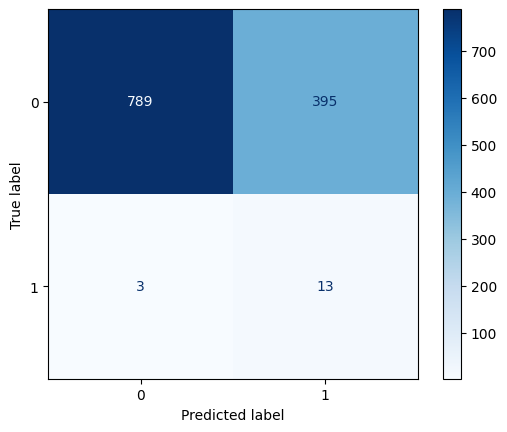

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
display = ConfusionMatrixDisplay(cm, display_labels = ['0', '1'])
display.plot(cmap = 'Blues')

SHAP Top 10 - Logistic Regression

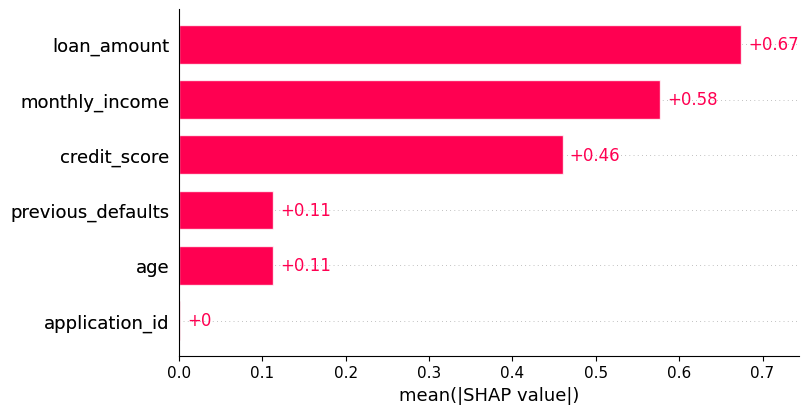

<Figure size 640x480 with 0 Axes>

In [ ]:
explainer = shap.Explainer(model, X_new)
shap_values = explainer(X_new)

shap.plots.bar(shap_values, max_display = 10)
plt.savefig('shap_top10.png', dpi = 300, bbox_inches = 'tight')

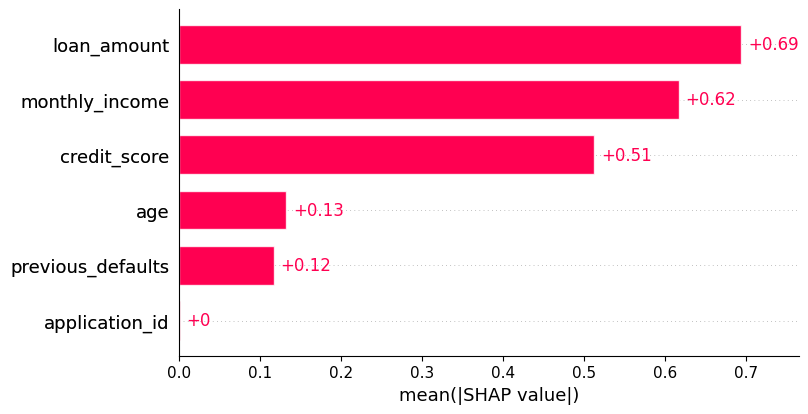

<Figure size 640x480 with 0 Axes>

In [ ]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

shap.plots.bar(shap_values, max_display = 10)
plt.savefig('shap_top10.png', dpi = 300, bbox_inches = 'tight')

Optuna - Logistic Regression

In [ ]:
def objective_lr_with_smote(trial):
    smote_k_neighbors = trial.suggest_int('smote_k_neighbors', 3, 10)

    C = trial.suggest_float('C', 1e-5, 1e2, log=True)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs'])
    max_iter = trial.suggest_int('max_iter', 100, 1000)

    pipeline = Pipeline([
        ('oversampler', SMOTE(random_state=42, k_neighbors=smote_k_neighbors, sampling_strategy='auto')),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(
            C=C,
            solver=solver,
            max_iter=max_iter,
            random_state=42,
            n_jobs=-1
        ))
    ])

    cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(pipeline, X_train, y_train, cv=cv_splitter, scoring='average_precision', n_jobs=-1)

    return -score.mean()

# --- Run Optuna Study ---
study = optuna.create_study(direction='minimize')
study.optimize(objective_lr_with_smote, n_trials=20, show_progress_bar=True)

# --- Extract Best Parameters ---
best_params_from_optuna = study.best_params

final_smote_k_neighbors = best_params_from_optuna['smote_k_neighbors']

final_lr_params = {
    'C': best_params_from_optuna['C'],
    'solver': best_params_from_optuna['solver'],
    'max_iter': best_params_from_optuna['max_iter'],
    'random_state': 42,
    'n_jobs': -1
}

# --- Build Final Pipeline ---
final_model_pipeline = Pipeline([
    ('oversampler', SMOTE(random_state=42, k_neighbors=final_smote_k_neighbors, sampling_strategy='auto')),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(**final_lr_params))
])

# --- Fit Final Pipeline on Original Training Data ---
final_model_pipeline.fit(X_train, y_train)

# --- Predict and Evaluate on Test Data ---
probs = final_model_pipeline.predict_proba(X_test)[:, 1]
y_pred_test = final_model_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_test)

print("Evaluasi Model Final pada Data Test")
print("Accuracy : {:.2f}".format(accuracy))
print(classification_report(y_test, y_pred_test))
print(f"ROC AUC pada Data Test: {roc_auc_score(y_test, probs):.4f}")
print(f"Average Precision (AUPRC) pada Data Test: {average_precision_score(y_test, probs):.4f}")

[I 2025-06-26 03:20:53,496] A new study created in memory with name: no-name-378db387-b6e7-40b9-bf15-1c26421a7e5f


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-26 03:20:56,068] Trial 0 finished with value: -0.049842981853192685 and parameters: {'smote_k_neighbors': 9, 'C': 3.1148284666037135e-05, 'solver': 'liblinear', 'max_iter': 135}. Best is trial 0 with value: -0.049842981853192685.
[I 2025-06-26 03:20:56,215] Trial 1 finished with value: -0.04723108112383724 and parameters: {'smote_k_neighbors': 3, 'C': 6.184747713355365, 'solver': 'lbfgs', 'max_iter': 619}. Best is trial 0 with value: -0.049842981853192685.
[I 2025-06-26 03:20:56,357] Trial 2 finished with value: -0.04757541009216084 and parameters: {'smote_k_neighbors': 7, 'C': 2.4568770778974742, 'solver': 'liblinear', 'max_iter': 703}. Best is trial 0 with value: -0.049842981853192685.
[I 2025-06-26 03:20:56,531] Trial 3 finished with value: -0.04887532822064931 and parameters: {'smote_k_neighbors': 9, 'C': 0.0010285220574935052, 'solver': 'lbfgs', 'max_iter': 345}. Best is trial 0 with value: -0.049842981853192685.
[I 2025-06-26 03:20:56,738] Trial 4 finished with value: 

Gradient Boosting

In [ ]:
model = xgb.XGBClassifier()
model.fit(X_new, y_new)

probs = model.predict_proba(X_test)[:, 1]
score = prob_to_score(probs)

y_pred_test = model.predict(X_test)
credit_scores_test = prob_to_score(probs)

In [ ]:
X_test_result_2 = X_test.copy()
X_test_result_2['Actual'] = y_test.values
X_test_result_2['Predicted'] = y_pred_test
X_test_result_2['Prob_Default'] = probs
X_test_result_2['Credit_Score'] = credit_scores_test

In [ ]:
X_test_result_2.head()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,Actual,Predicted,Prob_Default,Credit_Score
1782,502782,0.325538,-1.525653,0.817582,1,-0.789434,0,1,0.540094,300.0
3917,504917,0.148543,-0.164390,0.066169,0,1.642415,0,0,0.001898,368.0
221,501221,-1.621407,-1.504865,1.248734,0,0.657042,0,0,0.000232,429.0
2135,503135,0.768025,-1.145478,1.068565,0,0.113824,0,1,0.536081,300.0
5224,506224,-0.293944,0.902016,-0.193665,0,1.212894,0,0,0.000175,437.0


In [ ]:
file_path_excel = 'X_test_result_xgb.xlsx'
X_test_result_2.to_excel(file_path_excel, index=False)
print(f"DataFrame 'X_test_result' telah disimpan ke '{file_path_excel}'")

DataFrame 'X_test_result' telah disimpan ke 'X_test_result_xgb.xlsx'


In [ ]:
model = xgb.XGBClassifier()
model.fit(X_new, y_new)

probs_train = model.predict_proba(X_new)[:, 1]
y_pred_train = model.predict(X_new)
score_train = prob_to_score(probs_train)

print("\nLaporan Klasifikasi pada Data Training:")
print(classification_report(y_new, y_pred_train))

accuracy_train = accuracy_score(y_new, y_pred_train)
print("Accuracy Training : {:.2f}".format(accuracy_train))

print(f"ROC AUC pada Data Training: {roc_auc_score(y_new, probs_train):.4f}")
print(f"Average Precision (AUPRC) pada Data Training: {average_precision_score(y_new, probs_train):.4f}")

X_train_result_2 = X_new.copy()
X_train_result_2['Actual'] = y_new.values
X_train_result_2['Predicted'] = y_pred_train
X_train_result_2['Prob_Default'] = probs_train
X_train_result_2['Credit_Score'] = score_train


Laporan Klasifikasi pada Data Training:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4743
           1       1.00      1.00      1.00      4743

    accuracy                           1.00      9486
   macro avg       1.00      1.00      1.00      9486
weighted avg       1.00      1.00      1.00      9486

Accuracy Training : 1.00
ROC AUC pada Data Training: 1.0000
Average Precision (AUPRC) pada Data Training: 1.0000


In [ ]:
print("Laporan Klasifikasi pada Data Test:")
accuracy = accuracy_score(y_test, y_pred_test)
print(classification_report(y_test, y_pred_test))

print("Accuracy : {:.2f}".format(accuracy))
print(f"ROC AUC pada Data Test: {roc_auc_score(y_test, probs):.4f}")
print(f"Average Precision (AUPRC) pada Data Test: {average_precision_score(y_test, probs):.4f}")

Laporan Klasifikasi pada Data Test:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1184
           1       0.03      0.06      0.04        16

    accuracy                           0.96      1200
   macro avg       0.51      0.52      0.51      1200
weighted avg       0.97      0.96      0.97      1200

Accuracy : 0.96
ROC AUC pada Data Test: 0.7618
Average Precision (AUPRC) pada Data Test: 0.0318


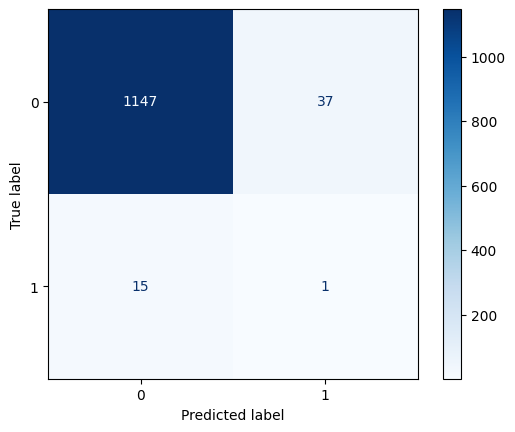

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
display = ConfusionMatrixDisplay(cm, display_labels = ['0', '1'])
display.plot(cmap = 'Blues')

SHAP Top 10 - Gradient Boosting

 98%|===================| 9286/9486 [00:37<00:00]       

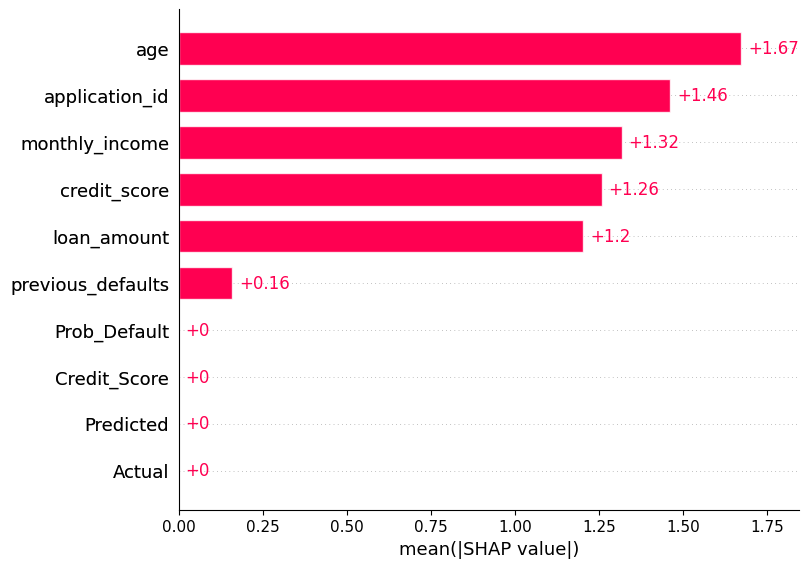

<Figure size 640x480 with 0 Axes>

In [ ]:
explainer = shap.Explainer(model, X_train_result_2)
shap_values = explainer(X_train_result_2)

shap.plots.bar(shap_values, max_display = 10)
plt.savefig('shap_top10.png', dpi = 300, bbox_inches = 'tight')

 98%|===================| 5876/6000 [00:25<00:00]       

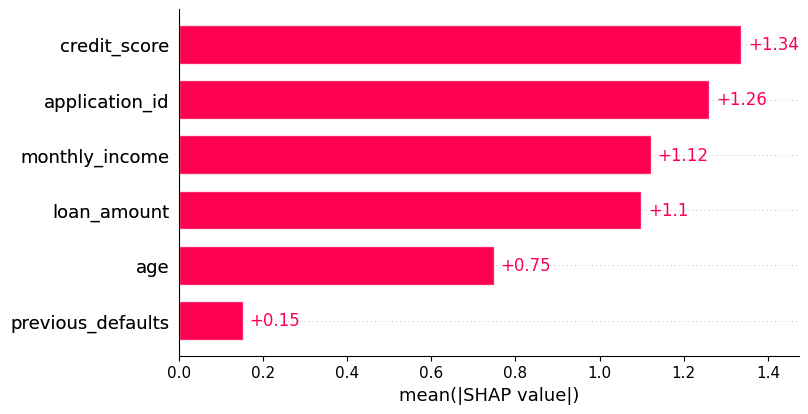

<Figure size 640x480 with 0 Axes>

In [ ]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

shap.plots.bar(shap_values, max_display = 10)
plt.savefig('shap_top10.png', dpi = 300, bbox_inches = 'tight')

Optuna - Gradient Boosting

In [ ]:
count_class_0_train = Counter(y_train)[0]
count_class_1_train = Counter(y_train)[1]
scale_pos_weight_value = count_class_0_train / count_class_1_train if count_class_1_train != 0 else 1.0

# --- Objective Function ---
def objective_xgb_with_smote(trial):
    smote_k_neighbors = trial.suggest_int('smote_k_neighbors', 3, 10)

    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 9)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    gamma = trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True)
    reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True)

    scale_pos_weight = scale_pos_weight_value

    pipeline = Pipeline([
        ('oversampler', SMOTE(random_state=42, k_neighbors=smote_k_neighbors, sampling_strategy='auto')),
        ('classifier', xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='aucpr',
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            reg_lambda=reg_lambda,
            reg_alpha=reg_alpha,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            n_jobs=-1,
            use_label_encoder=False,
            verbose=-1
        ))
    ])

    cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(pipeline, X_train, y_train, cv=cv_splitter, scoring='average_precision', n_jobs=-1)

    return -score.mean()

# --- Run Optuna Study ---
study = optuna.create_study(direction='minimize')
study.optimize(objective_xgb_with_smote, n_trials=20, show_progress_bar=True)

# --- Extract Best Parameters ---
best_params_from_optuna = study.best_params

final_smote_k_neighbors = best_params_from_optuna['smote_k_neighbors']

final_xgb_classifier_params = {
    key: value for key, value in best_params_from_optuna.items()
    if not key.startswith('smote_')
}

final_xgb_classifier_params['random_state'] = 42
final_xgb_classifier_params['n_jobs'] = -1
final_xgb_classifier_params['objective'] = 'binary:logistic'
final_xgb_classifier_params['eval_metric'] = 'aucpr'
final_xgb_classifier_params['use_label_encoder'] = False
final_xgb_classifier_params['scale_pos_weight'] = scale_pos_weight_value
final_xgb_classifier_params['verbose'] = -1

# --- Build Final Pipeline ---
final_model_pipeline = Pipeline([
    ('oversampler', SMOTE(random_state=42, k_neighbors=final_smote_k_neighbors, sampling_strategy='auto')),
    ('classifier', xgb.XGBClassifier(**final_xgb_classifier_params))
])

# --- Fit Final Pipeline on Original Training Data ---
final_model_pipeline.fit(X_train, y_train)

# --- Predict and Evaluate on Test Data ---
probs = final_model_pipeline.predict_proba(X_test)[:, 1]
y_pred_test = final_model_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_test)

print("===== Evaluasi Model Final pada Data Test =====")
print("Accuracy : {:.2f}".format(accuracy))
print(classification_report(y_test, y_pred_test))
print(f"ROC AUC pada Data Test: {roc_auc_score(y_test, probs):.4f}")
print(f"Average Precision (AUPRC) pada Data Test: {average_precision_score(y_test, probs):.4f}")

[I 2025-06-26 03:22:04,831] A new study created in memory with name: no-name-885a1d66-8fa2-4023-9914-271e889a58e3


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-26 03:22:12,246] Trial 0 finished with value: -0.03459236853881501 and parameters: {'smote_k_neighbors': 7, 'n_estimators': 791, 'learning_rate': 0.08746930968487117, 'max_depth': 7, 'subsample': 0.8216290585256628, 'colsample_bytree': 0.8395096263568145, 'gamma': 4.1352426910829e-06, 'reg_lambda': 1.9702953181746884e-06, 'reg_alpha': 1.1471472996619794e-05}. Best is trial 0 with value: -0.03459236853881501.
[I 2025-06-26 03:22:14,180] Trial 1 finished with value: -0.048021418601422325 and parameters: {'smote_k_neighbors': 7, 'n_estimators': 243, 'learning_rate': 0.011733485347463003, 'max_depth': 9, 'subsample': 0.8008211369488939, 'colsample_bytree': 0.6630884433251294, 'gamma': 0.01416994156204817, 'reg_lambda': 1.2027696289139014e-07, 'reg_alpha': 1.4441603474569222}. Best is trial 1 with value: -0.048021418601422325.
[I 2025-06-26 03:22:16,345] Trial 2 finished with value: -0.0413828621507477 and parameters: {'smote_k_neighbors': 3, 'n_estimators': 729, 'learning_rate':

In [ ]:
loan_5jt_indices = df[(df['loan_amount'] >= 4_900_000) & (df['loan_amount'] <= 5_100_000)].index
print(loan_5jt_indices)

if not loan_5jt_indices.empty:
    # Ambil indeks pertama dari baris yang ditemukan
    target_index = loan_5jt_indices[0]

    # 2. Gunakan indeks tersebut untuk mendapatkan baris yang sama dari X_test_scaled_df
    loan_5jt_scaled_data = df.loc[[target_index]]

    print("Data Loan 5 Juta (sudah di-scaling):")
    print(loan_5jt_scaled_data)

    # Anda bisa juga mendapatkan application_id dari indeks yang sama
    loan_5jt_app_id = df.loc[target_index]
    print(f"\nApplication ID untuk loan ini: {loan_5jt_app_id}")

    # Sekarang 'loan_5jt_scaled_data' ini siap digunakan untuk SHAP atau prediksi individual
    # Misalnya:
    # probs_5jt = model.predict_proba(loan_5jt_scaled_data)[:, 1]
    # shap_values = explainer.shap_values(loan_5jt_scaled_data)

else:
    print("Tidak ditemukan aplikasi pinjaman 5 Juta di X_test.")

Index([  25,   32,   68,  127,  156,  166,  277,  335,  510,  515,  518,  625,
        663,  706,  772,  810,  832,  881,  921,  925, 1058, 1080, 1101, 1153,
       1253, 1488, 1582, 1588, 1620, 1625, 1647, 1704, 1721, 1727, 1806, 1964,
       2076, 2121, 2179, 2202, 2310, 2450, 2531, 2564, 2670, 2735, 2740, 2826,
       2849, 2957, 2996, 3023, 3240, 3316, 3629, 3636, 3736, 3810, 3901, 3991,
       4077, 4118, 4233, 4434, 4444, 4474, 4650, 4652, 4696, 4893, 4960, 4992,
       5053, 5232, 5255, 5293, 5317, 5348, 5384, 5409, 5420, 5434, 5544, 5592,
       5803, 5842, 5883],
      dtype='int64')
Data Loan 5 Juta (sudah di-scaling):
    application_id  age  monthly_income  loan_amount  previous_defaults  \
25          501025   31        12871140      4999366                  0   

    credit_score  default  
25           433        0  

Application ID untuk loan ini: application_id         501025
age                        31
monthly_income       12871140
loan_amount           4999366
prev

In [ ]:
if 25 in X_train_result_1.index:
    print("Indeks 25 ditemukan di X_train menggunakan .loc[]:")
    print(X_train_result_1.loc[25])
else:
    print("Indeks 25 TIDAK ditemukan di X_train.")

print("-" * 30)

# Coba cari di X_test
if 25 in X_test.index:
    print("Indeks 25 ditemukan di X_test menggunakan .loc[]:")
    print(X_test.loc[25])
else:
    print("Indeks 25 TIDAK ditemukan di X_test.")

print("-" * 30)

Indeks 25 ditemukan di X_train menggunakan .loc[]:
application_id       505769.000000
age                      -0.116949
monthly_income           -0.134770
loan_amount               0.506508
previous_defaults         0.000000
credit_score             -1.313703
Actual                    0.000000
Predicted_Prob            0.673171
Credit_Score            300.000000
Predicted_Label           1.000000
Name: 25, dtype: float64
------------------------------
Indeks 25 TIDAK ditemukan di X_test.
------------------------------


In [ ]:
if 25 in X_train_result_2.index:
    print("Indeks 25 ditemukan di X_train menggunakan .loc[]:")
    print(X_train_result_2.loc[25])
else:
    print("Indeks 25 TIDAK ditemukan di X_train.")

print("-" * 30)

# Coba cari di X_test
if 25 in X_test.index:
    print("Indeks 25 ditemukan di X_test menggunakan .loc[]:")
    print(X_test.loc[25])
else:
    print("Indeks 25 TIDAK ditemukan di X_test.")

print("-" * 30)

Indeks 25 ditemukan di X_train menggunakan .loc[]:
application_id       505769.000000
age                      -0.116949
monthly_income           -0.134770
loan_amount               0.506508
previous_defaults         0.000000
credit_score             -1.313703
Actual                    0.000000
Predicted                 0.000000
Prob_Default              0.058213
Credit_Score            300.000000
Name: 25, dtype: float64
------------------------------
Indeks 25 TIDAK ditemukan di X_test.
------------------------------
